In [ ]:
from google.colab import drive
drive.mount('drive')

!cp "drive/MyDrive/Datasets/GridGuid data/data.zip" ./data.zip
!unzip ./data.zip

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    './train_data/', image_size=(70,70), batch_size=10, shuffle=True,
    color_mode='grayscale'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    './val_data/', image_size=(70,70), batch_size=3, shuffle=False,
    color_mode='grayscale'
)

Found 5562 files belonging to 10 classes.
Found 30 files belonging to 10 classes.


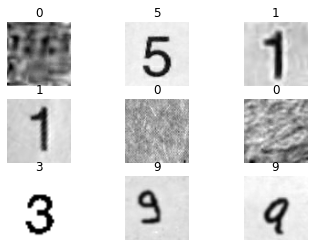

In [8]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_ds.class_names[labels[i]])
        plt.gray()
        plt.axis('off')


In [9]:
preprocessing = tf.keras.layers.experimental.preprocessing

resize_and_rescale = tf.keras.Sequential([
    preprocessing.Resizing(70,70),
    preprocessing.Rescaling(1.0/255.0)
])


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)


In [11]:
num_classes = 10

model = tf.keras.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(64, 3, activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(.5),

    tf.keras.layers.Conv2D(32, 3, activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(.5),

    tf.keras.layers.Conv2D(32, 3, activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


In [12]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(0.0001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

log = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35
)

Epoch 1/35
557/557 [==============================] - 16s 7ms/step - loss: 2.1417 - accuracy: 0.2983 - val_loss: 2.5014 - val_accuracy: 0.1333
Epoch 2/35
557/557 [==============================] - 3s 6ms/step - loss: 1.5417 - accuracy: 0.4939 - val_loss: 1.6049 - val_accuracy: 0.6333
Epoch 3/35
557/557 [==============================] - 3s 6ms/step - loss: 1.2595 - accuracy: 0.6012 - val_loss: 1.2351 - val_accuracy: 0.6333
Epoch 4/35
557/557 [==============================] - 3s 6ms/step - loss: 1.0403 - accuracy: 0.6724 - val_loss: 0.9528 - val_accuracy: 0.7667
Epoch 5/35
557/557 [==============================] - 3s 6ms/step - loss: 0.8319 - accuracy: 0.7424 - val_loss: 0.6903 - val_accuracy: 0.8000
Epoch 6/35
557/557 [==============================] - 3s 6ms/step - loss: 0.6757 - accuracy: 0.7895 - val_loss: 0.5646 - val_accuracy: 0.8333
Epoch 7/35
557/557 [==============================] - 3s 6ms/step - loss: 0.5580 - accuracy: 0.8234 - val_loss: 0.5050 - val_accuracy: 0.8667
Epoch

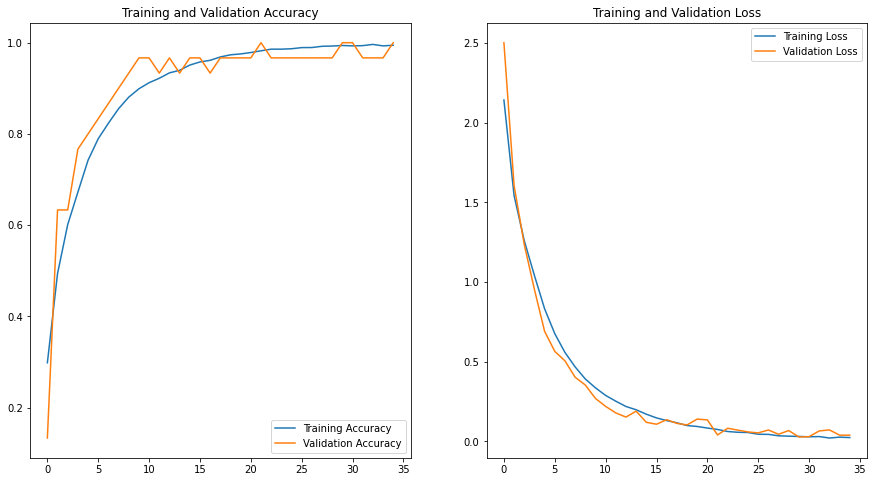

In [13]:
acc = log.history['accuracy']
val_acc = log.history['val_accuracy']
loss = log.history['loss']
val_loss = log.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(122)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


1/1 [==============================] - 0s 21ms/step


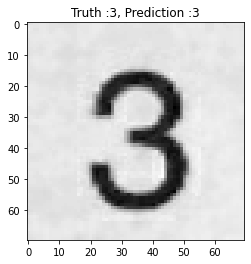

In [24]:
class_names = [0,1,2,3,4,5,6,7,8,9]
import numpy as np

for images_batch, labels_batch in val_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    plt.title(f'Truth :{class_names[first_label]}, Prediction :{class_names[np.argmax(model.predict(images_batch)[0])]}')


### Saving the model

In [25]:
model.save('./model')

In [26]:
from tensorflow import keras
loaded_model = keras.models.load_model('./model')


In [27]:
model.evaluate(train_ds)

557/557 [==============================] - 2s 3ms/step - loss: 0.0358 - accuracy: 0.9915


[0.03581099212169647, 0.9915497899055481]

In [28]:
loaded_model.evaluate(val_ds)

10/10 [==============================] - 0s 3ms/step - loss: 0.0386 - accuracy: 1.0000


[0.038598477840423584, 1.0]

In [29]:
!zip -r ./model.zip ./model/*

  adding: model/assets/ (stored 0%)
  adding: model/fingerprint.pb (stored 0%)
  adding: model/keras_metadata.pb (deflated 93%)
  adding: model/saved_model.pb (deflated 90%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model/variables/variables.index (deflated 66%)


#### Conver to tflite

In [30]:
# quantisation 
# quantise aware training

import tensorflow as tf

saved_dir = './model'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
model_lite = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(model_lite)
